In [1]:
%autosave 80000

Autosaving every 80000 seconds


In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import pymc3 as pm 
import os 

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

In [3]:
from scipy import stats
from pymc3.distributions import draw_values
from pymc3.distributions import generate_samples
from pymc3.theanof import floatX
from pymc3.distributions.dist_math import bound
from pymc3.distributions import (Continuous, draw_values, generate_samples)

def assert_negative_support(var, label, distname, value=-1e-6):
    # Checks for evidence of positive support for a variable
    if var is None:
        return
    try:
        # Transformed distribution
        support = np.isfinite(var.transformed.distribution.dist
                              .logp(value).tag.test_value)
    except AttributeError:
        try:
            # Untransformed distribution
            support = np.isfinite(var.distribution.logp(value).tag.test_value)
        except AttributeError:
            # Otherwise no direct evidence of non-positive support
            support = False

    if np.any(support):
        msg = "The variable specified for {0} has negative support for {1}, ".format(
            label, distname)
        msg += "likely making it unsuitable for this parameter."
        warnings.warn(msg)

def get_tau_sigma(tau=None, sigma=None):
    if tau is None:
        if sigma is None:
            sigma = 1.
            tau = 1.
        else:
            tau = sigma**-2.
    else:
        if sigma is not None:
            raise ValueError("Can't pass both tau and sigma")
        else:
            sigma = tau**-.5
    tau = 1. * tau
    sigma = 1. * sigma
    return floatX(tau), floatX(sigma)

In [4]:
class weighted_Normal(pm.distributions.Continuous):

    def __init__(self, mu=0, sigma=None, tau=None, sd=None, weight =None,**kwargs):
        if sd is not None:
            sigma = sd
        tau, sigma = get_tau_sigma(tau=tau, sigma=sigma)
        self.sigma = self.sd = tt.as_tensor_variable(sigma)
        self.tau = tt.as_tensor_variable(tau)
        self.weight = tt.as_tensor_variable(weight)

        self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(floatX(mu))
        self.variance = 1. / self.tau

        assert_negative_support(sigma, 'sigma', 'Normal')
        assert_negative_support(tau, 'tau', 'Normal')

        super().__init__(**kwargs)

    def random(self, point=None, size=None):
        
        mu, tau, _ = draw_values([self.mu, self.tau, self.sigma],
                                 point=point, size=size)
        return generate_samples(stats.norm.rvs, loc=mu, scale=tau**-0.5,
                                dist_shape=self.shape,
                                size=size)

    def logp(self, value):
        """
        Sum of Squares
        
        """
        sigma = self.sigma
        tau = self.tau
        mu = self.mu
        weight = self.weight
        
        logp = weight *  -  tt.sqr(value - mu)/(2.0 * sigma * sigma)
        return logp.sum()


In [6]:
import pandas as pd
cwd = os.chdir("/Users/ArgonLab/Downloads/missoula")
dfx = pd.read_csv('f_b1_data_y.csv', engine = 'python')

In [7]:
dfx.head()

,Age,Age_Er,Ar40_,Ar40_Er,Ar39_,Ar39_Er,Pwr_Achieved,Dur_Heating_At_Req_Pwr,Run_Date,temp,temp_err,time,Da2,Da2_err
0,414.8405,1.179656,6.291370,0.008424,0.188120,0.000354,430,300,8/23/2019,430.413793,3.017286,296.684,5.970000e-07,3.260000e-08
1,302.7490,2.233911,1.680839,0.003359,0.073792,0.000226,444,300,8/23/2019,444.434483,2.463171,296.688,5.600000e-07,1.850000e-07
2,327.0605,2.271607,1.694057,0.003163,0.071656,0.000216,457,300,8/23/2019,457.434483,2.644528,296.672,7.200000e-07,8.880000e-09
3,329.7432,2.319522,1.631306,0.002967,0.069356,0.000206,468,300,8/23/2019,468.579310,2.610825,297.672,8.590000e-07,7.410000e-09
4,319.1108,2.004288,1.800285,0.003065,0.080298,0.000216,483,300,8/23/2019,483.134483,2.340607,296.638,1.310000e-06,1.590000e-08


In [8]:
# Age 
age = dfx['Age'].values
data = age
age_err = dfx['Age_Er'].values
age_m = age
N = age.shape[0]
age = data[data > 0]
ar39 = dfx['Ar39_'].values


In [10]:
# Part 1 ThermoCouple T Calibration 
## Step 1: Pyrometer Calibration
import os 
cwd = os.getcwd()
cwd = os.chdir("/Users/ArgonLab/Downloads")
df1 = pd.read_csv("PyroApril2018.csv")
c1 = df1.iloc[:,0:1]
c2 = df1.iloc[:,1:2]
x1 = c1.values
x2 = c2.values
x1 = x1[x1 >=0]
x2 = x2[x2 >=0]
ThermoT = x2
PyroT = x1
zpt = np.polyfit(x1,x2,3)

In [11]:
da2 = dfx['Da2'].values
da2_err = dfx['Da2_err'].values
temp1 = dfx['temp'].values
time = dfx['time'].values

temp = np.polyval(zpt, temp1)
tempk = temp + 273.15


In [12]:
sns.set_style('ticks')
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

In [13]:
def cumrel(x): 
    y = np.cumsum(x)
    z = y/y.max()
    return z

In [14]:
ar39 = cumrel(ar39)
age = age
age_err = age_err
data3 = ar39

In [15]:
# Plotting parameters

age_plot = np.insert(age,
                     0, age[0])
age_plot_err =  np.insert(age_err, 
                         0, age_err[0])
ar39_plot = np.insert(ar39,
                      0, 0)

In [16]:
tplot = 1e4/tempk
arr_err = da2_err/da2

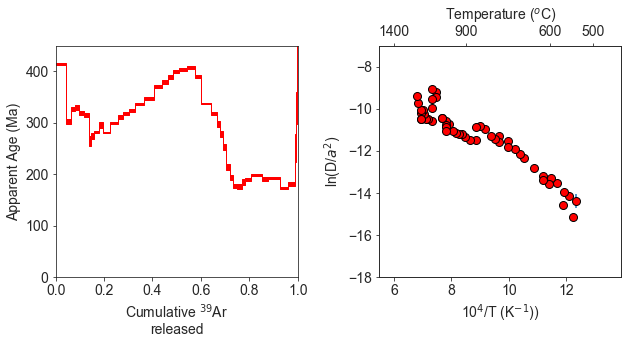

In [17]:
fig, ax = plt.subplots(1,2, figsize= (9,5))
ax[0].fill_between(ar39_plot, 
                age_plot + 2*age_plot_err, 
                age_plot - 2*age_plot_err, 
                color = 'red', 
                step = 'pre')

ax[0].set_ylim(0, 450)
ax[0].set_xlim(0,1)

ax[0].set_ylabel('Apparent Age (Ma)')
ax[0].set_xlabel('Cumulative $^{39}$Ar\nreleased');


ax[1].errorbar(tplot[1:N], np.log(da2[1:N]), yerr = arr_err[1:N],
              fmt = 'o', 
        markersize = 8, 
        markerfacecolor = 'red', 
        markeredgecolor = 'k')


ax2 = ax[1].twiny()

Tdc = np.array([500,  600, 900,  1400])
Tp = 10e3/(Tdc + 273.15)
labels = list(['500', '600', '900',   
              '1400'])
ax2.plot(tplot, np.log(da2), alpha = 0)
ax2.set_xlabel('Temperature ($^{o}$C)')
ax[1].set_xlim(Tp.min() - 0.5, Tp.max()+ 1)
ax2.set_xlim(Tp.min() - 0.5, Tp.max()+ 1)

ax2.set_xlabel('Temperature ($^{o}$C)')
ax2.set_xticks(Tp)
ax2.set_xticklabels(labels)

ax[1].set_xlabel('10$^{4}$/T (K$^{-1}$))')
ax[1].set_ylabel('ln(D/$a^{2}$)')
ax[1].set_ylim(-18, -7)
plt.tight_layout()


In [18]:
def inc_mdd(ea, d0, a,phi,temp, t):
    R = 8.314e-3
    D0t = ((phi/a)**2)* d0 * np.exp(-ea/(R*temp))*t
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    aa1 = np.sqrt(np.pi) * a**2 * R * temp**2
    bb1 = (phi/a)**2 * d0*np.exp(-ea/(R*temp))*t
    dd1 = 3 * d0 * ea * t * phi**2
    z1 = (dd1 * np.exp(-ea/(R*temp)))/(aa1 * np.sqrt(bb1))
    aa2 = a**2 * R *temp**2
    bb2 = (phi/a)**2 * d0*np.exp(-ea/(R*temp))*t
    cc1 = 3 * d0 * ea * t * phi**2 * np.exp(-ea/(R*temp))
    z2 = cc1/(np.sqrt(np.pi) * aa2 * np.sqrt(bb2)) - cc1/(aa2) 
    aa3 = a**2 * R * temp**2
    bb3 = (phi/a)**2 * d0*np.exp(-ea/(R*temp))*t
    cc2 = 6 * d0 * ea * t * phi**2
    z3 = (cc2 * np.exp(-(np.pi**2 * bb3) - (ea/(R*temp)))/(aa3))
    Q = tt.switch(q <= 0.9,
                z2,
                 z3)
    T = tt.switch(q < 0.1, 
                  z1,
                  Q)
    return T

In [19]:
data = age
arr_data = np.log(da2)
arr_data
tempk;
arr_err = da2_err/da2

In [20]:
from theano import shared
err_age = shared(age_err)
t_obs = dfx['time'].values
t_obs = t_obs
tempk = tempk
data = data
N = data.shape[0]
N

55

In [21]:
"""
Create Theano shared Variables
"""
age_err_data = shared(age_err[:N])
arr_err_data = shared((da2_err[:N] /da2[:N]))
age_data = shared(data)
arrh_data = shared(arr_data)

In [22]:
"""
Stick Breaking 
"""
import pymc3.distributions.transforms as tr
from theano import tensor as tt
def stick_break(beta): 
    pr = tt.concatenate([[1], 
                         tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * pr


Text(0, 0.5, 'Probability density')

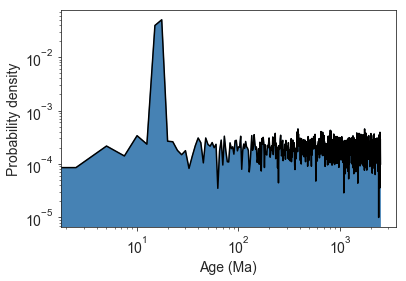

In [23]:
"""
Age Prior
"""
x1 = np.random.uniform(0, 2500, 10000)
x2 = np.random.normal(16.3, 0.2, 10000)
age_prior = np.concatenate((x1,x2), axis = 0)

grid = np.linspace(0, 2500, 1000)

from scipy.stats import gaussian_kde
y = gaussian_kde(age_prior, 
                bw_method = 0.00075)
pdf_points = y.evaluate(grid)

plt.plot(grid, pdf_points, color = 'k')
plt.fill_between(grid, 
                pdf_points, 
                color= 'steelblue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Age (Ma)')
plt.ylabel('Probability density')

In [24]:
"""
Number of Components and Domains
Truncate point
"""

k = 20

m = 10

"""
Open Model
"""

Q = pm.Model()
with Q: 
    """
    Number of Components
    """
    alpha = pm.Gamma('alpha', 
                         1., 1.)

    beta = pm.Beta('beta', 1., alpha, 
                      shape = k)

    K_w = stick_break(beta)
    
    K = pm.Deterministic('K', 
                        K_w/K_w.sum(axis = 0,
                                    keepdims = True))
    C = pm.Categorical('C', 
                       p = K,
                       shape = (N,))
    
    """
    Number of Domains
    """
    phi = pm.Dirichlet('phi', 
                      np.ones(m), 
                      shape = (k,m))
    
    D = pm.Categorical('D', 
                       p = phi[C], 
                       shape = N)

/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [25]:
with Q: 
    """
    Diffusion Kinetics
    """
    ea_mean = pm.Uniform('Ea_mean', 
                    lower = 80,
                    upper = 500,             
                    shape = k,
                         testval = np.linspace(110, 400, k))

    ea_sd = pm.HalfNormal('ea_sd',
                         sd = ea_mean,
                         shape = k)
    
    ea = pm.Normal('Ea', 
                  mu = ea_mean,
                  sd = ea_sd,
                  shape = k)
    
    d0_mean = pm.Uniform('d0_mean', 
                         lower = 0.0,
                         upper = 10000,
                         shape = k,
                         testval = np.linspace(0.00075, 7500, k))
    
    d0_sd = pm.HalfNormal('d0_sd', 
                         sd = d0_mean/10,
                         shape = k)
    
    d0 = pm.Normal('d0',
                 mu = d0_mean,
                 sd = d0_sd,
                 shape = k)

In [26]:
import pymc3.distributions.transforms as tr
with Q: 
    """
    MDD grain size or domain size 
    """
    a = pm.Uniform('a', lower = 0.00001, 
                  upper = 0.0032, 
                  shape = (k,m),
                  testval = np.linspace(0.003, 0.00005,m))

In [27]:
with Q: 
    """
    Age Prior
    """
    age_mean = pm.Interpolated('age_mean',
                              grid,
                              pdf_points,
                              shape = k,
                              testval = data.mean())
    
    age_sd = pm.HalfNormal('age_sd', 
                          sd = age_mean/10,
                          shape = k)
    
    age_model = pm.Normal('age_model', 
                          mu = age_mean, 
                          sd = age_sd, 
                          shape = k)
    
    pm.Potential('age_con', 
                tt.switch(age_model < 0, 
                         -np.inf, 0) +
                tt.switch(age_model > 2500,
                         -np.inf, 0))
    
    


In [28]:
with Q: 
    """
    Indexing
    """
    age_comp = pm.Deterministic('age_comp',
                                age_model[C])
    ea_comp = pm.Deterministic('ea_comp',
                               ea[C])
    d0_comp = pm.Deterministic('d0_comp',
                               d0[C])
    phi_comp = pm.Deterministic('phi_comp',
                                K[C])
    a_domain = pm.Deterministic("a_domain",
                                a[C,D])
    phi_domain = pm.Deterministic('phi_domain',
                                  phi[C,D])

/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [29]:
with Q:
    """
    Age Model
    """
    Z2 = K[C] * inc_mdd(ea[C], 
                d0[C], 
                a[C,D], 
                phi[C,D],
                tempk[:,None],
                t_obs[:,None])
    
    Y_sum2 = Z2.sum(axis = 1)
    
    XX = (Z2 * age_model[C]).sum(axis = 1)

    mu2 = (XX/Y_sum2)

In [30]:
with Q: 
    """
    Incremental Release Trace
    """
    inc_rel = pm.Deterministic('inc_rel', Y_sum2)

In [31]:
with Q:
    """
    Arrhenius Model
    """
    R = 8.314e-3
    
    y2 = K[C] * (((phi[C,D]/a[C,D])**2) \
                 * d0[C] * np.exp(-ea[C]/(R*tempk)))
    
    mu1 = tt.log(y2)

/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


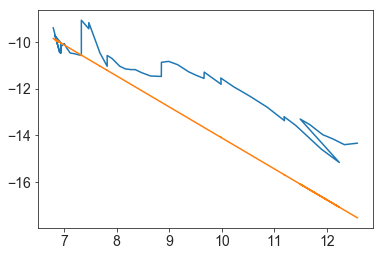

In [32]:
plt.plot(tplot, np.log(da2))
plt.plot(tplot, mu1.tag.test_value)

In [33]:
"""
Calculate Model weights
"""
def logp_w(data, model, err): 
    y =   - ((data - model)**2)/(2*err * err)
    return y.sum()

with Q: 

    y1 = logp_w(data,
                mu2.tag.test_value,
                age_err)
    
    y2 = logp_w(arr_data[0:N-1],
                mu1.tag.test_value[0:N-1],
                arr_err[0:N-1])
    
    weight = y1/y2


In [34]:
1/weight

5448.85925577172

In [35]:
with Q: 
    """
    Arrhenius Likelihood
    """
    obs2 = weighted_Normal('obs2', mu1[0:N-1],
                     arr_err_data[0:N-1], 
                     observed = arrh_data[0:N-1], 
                           weight = weight)

In [36]:
with Q: 
    """
    Age Likelihood
    """
    obs1 = weighted_Normal('obs1', mu = mu2, 
                           sd = age_err_data, 
                           observed = age_data, 
                          weight = 1)

In [37]:
Q.check_test_point()

/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wil

alpha_log__                -1.00
beta_logodds__            -27.73
C                         -38.12
phi_stickbreaking__      -204.48
D                        -126.64
Ea_mean_interval__        -33.26
ea_sd_log__               -15.40
Ea                       -123.34
d0_mean_interval__        -49.40
d0_sd_log__               -15.40
d0                       -113.54
a_interval__             -413.28
age_mean_interval__       -46.94
age_sd_log__              -15.40
age_model                 -96.55
obs2                  -986639.60
obs1                  -986639.60
Name: Log-probability of test_point, dtype: float64

In [38]:
SAMPLES = 50000
BURN = 1200000
SEED = np.random.seed(123)

with Q:
    step1 = pm.CategoricalGibbsMetropolis([C,D]) 
    
    step2 = pm.Metropolis([d0_mean, d0_sd, d0,
                           ea_mean, ea_sd, ea, 
                           age_model, age_sd, age_mean,
                           phi, a],
                         scaling = 100)
    
    
    step3 = pm.Metropolis([alpha, beta])
        
    trace = pm.sample(SAMPLES, tune = BURN, 
                     step = [step1,
                             step2, 
                            step3],
                     random_seed = SEED)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [D, C]
>CompoundStep
>>Metropolis: [a]
>>Metropolis: [phi]
>>Metropolis: [age_mean]
>>Metropolis: [age_sd]
>>Metropolis: [age_model]
>>Metropolis: [Ea]
>>Metropolis: [ea_sd]
>>Metropolis: [Ea_mean]
>>Metropolis: [d0]
>>Metropolis: [d0_sd]
>>Metropolis: [d0_mean]
>CompoundStep
>>Metropolis: [beta]
>>Metropolis: [alpha]
/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 4 chains: 100%|██████████| 5000000/5000000 [37:54:20<00:00, 36.64draws/s]   
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of e

Text(0, 0.5, 'Log probability')

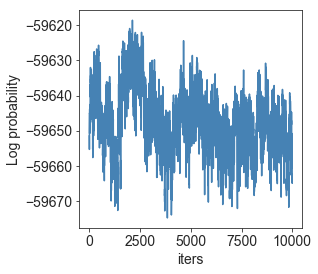

In [39]:
SAMPLES = 10000
logp_model = Q.logp

logp = [logp_model(i) for i in trace[-SAMPLES:]]
logp_x = np.array([logp])
logp_x = logp_x.reshape(SAMPLES)

plt.figure(figsize = (4,4))
plt.plot(logp_x,
        color = 'steelblue')
plt.xlabel('iters')
plt.ylabel('Log probability')

Text(0, 0.5, 'Age (Ma)')

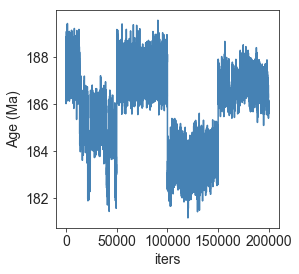

In [40]:
plt.figure(figsize = (4,4))
plt.plot(trace['age_model'][:,0],
        color = 'steelblue')
plt.xlabel('iters')
plt.ylabel('Age (Ma)')

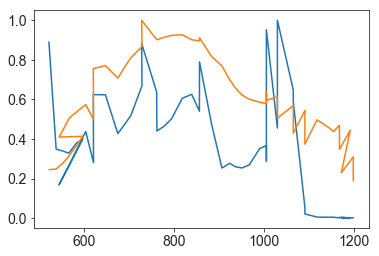

In [41]:
ar39 = dfx['Ar39_'].values
plt.plot(temp[:N],
         ar39[:N]/ar39[:N].max())
plt.plot(temp[:N], 
         trace['inc_rel'].mean(axis = 0)/trace['inc_rel'].mean(axis = 0).max())

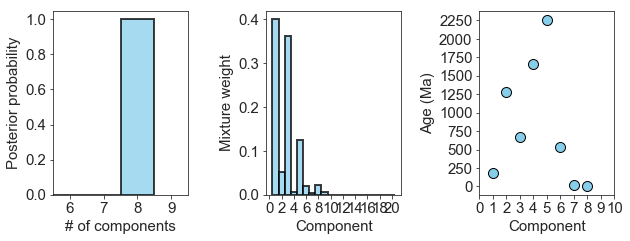

In [42]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

fig, ax = plt.subplots(1, 3, figsize = (9, 3.6))
n_comp = np.apply_along_axis(lambda x: np.unique(x).size, 
                            1, trace['C'][-SAMPLES::10])

n_comp =  n_comp+ 1
ncmp = n_comp.mean(axis = 0).astype(int)
bins = np.arange(n_comp.min() -2 , n_comp.max() + 2)

ax[0].hist(n_comp ,
        bins=bins,
        density=True,
        lw= 2,
        alpha=0.75, 
       edgecolor = 'k', 
        facecolor = 'skyblue');

ax[0].set_xticks(bins + 0.5);
ax[0].set_xticklabels(bins);
ax[0].set_xlim(bins.min(),bins.max() + 1);
ax[0].set_xlabel('# of components');



plot_w = np.arange(k) + 1

ax[1].bar(plot_w - 0, trace['K'][-SAMPLES::10].mean(axis=0),
          width=1., lw=2, 
      edgecolor = 'k', alpha = 0.75, 
         facecolor = 'skyblue');

ax[1].set_xlabel('Component');

ax[1].set_ylabel('Mixture weight');

ax[1].locator_params(axis='x', nbins=12)

ax[2].errorbar(np.linspace(1, ncmp,ncmp),
             trace['age_model'][-SAMPLES::10].mean(axis = 0)[:ncmp], 
             yerr = 2*trace['age_model'][-SAMPLES::10].std(axis = 0)[:ncmp], 
             fmt ='o', 
             markersize = 10, 
             markeredgecolor = 'k', 
             markerfacecolor = 'skyblue')

ax[2].set_xlabel('Component');

ax[2].set_ylabel('Age (Ma)');
ax[0].set_ylabel('Posterior probability')

ax[2].locator_params(axis='x', nbins=12)
ax[2].locator_params(axis='y', nbins=12)
ax[2].set_xlim(0, 10)


plt.tight_layout()


In [43]:
np.set_printoptions(suppress=True)
print(trace['age_model'][-SAMPLES::10].mean(axis = 0).round(2))


[ 186.67 1279.45  668.2  1661.57 2258.88  539.92   15.95    1.3  1860.3
  956.24  467.84 1281.01  667.67  592.88 1290.68 1303.68  622.19  201.21
   17.49  654.99]


In [44]:
trace['age_model'][-SAMPLES::10].std(axis = 0).round(2)

array([ 0.45,  5.44,  5.49,  6.12,  6.13,  2.04,  1.8 ,  0.16,  5.25,
        3.98,  5.66,  8.13,  2.1 , 10.65,  2.78,  2.03,  8.04,  4.13,
        1.51,  3.22])

In [45]:
from scipy import stats
with Q: 
    ppc = pm.sample_ppc(trace,
                        1000)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  after removing the cwd from sys.path.
  0%|          | 0/1000 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inpu

In [46]:
# Mean Predictive Models
Z2 = ppc['obs1'].mean(axis = 0)
low2, high2 = np.percentile(ppc['obs1'], 
                            [50 - 34, 50 + 34], 
                            axis = 0)

# Frel_model
inc_model = trace['inc_rel'].mean(axis = 0)
frel_model = cumrel(inc_model)

In [47]:
sns.set_style('ticks')
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

# Plotting parameters 
ar39 = cumrel(ar39)

low2_plot = np.insert(low2, 0, low2[0])
high2_plot = np.insert(high2, 0, high2[0])
z2_plot = np.insert(Z2, 0, Z2[0])
frel_model_plot = np.insert(frel_model, 0, 0)

data2_plot = np.insert(ar39, 0, 0)
data_plot = np.insert(data, 0, data[0])
age_err_plot = np.insert(age_err, 0, age_err[0])


(0, 700)

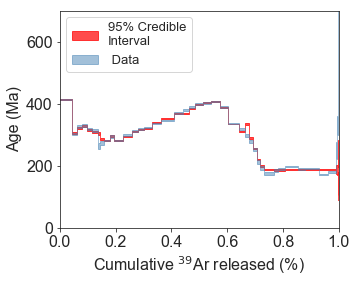

In [48]:
fig = plt.figure(figsize = (5, 4))

plt.fill_between(ar39_plot, low2_plot, 
                 high2_plot, 
                 alpha = 0.7, 
                color = 'r', 
                label = '95% Credible\nInterval', 
                step = 'pre')

plt.fill_between(ar39_plot, 
                age_plot + 2*age_plot_err, 
                age_plot - 2*age_plot_err, 
                color = 'steelblue', 
                step = 'pre', 
                label = ' Data',
                alpha =0.5)


plt.xlabel('Cumulative $^{39}$Ar released (%)')
plt.ylabel('Age (Ma)')
plt.legend(loc = 2, fontsize = 13)
plt.xlim(0, 1)
plt.ylim(0, 700)

In [49]:
def arr_plot(ea, d0, a, temp): 
    R = 8.314e-3
    da2 = (d0/a.max()**2) * np.exp(-ea/(R*temp))
    
    return np.log(da2)

In [50]:
tplot = 10000/tempk

# Mean Predictive Models
Z1 = ppc['obs2'].mean(axis = 0)
low1, high1 = np.percentile(ppc['obs2'], [50 - 34, 50 + 34], axis = 0)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


(0, 450)

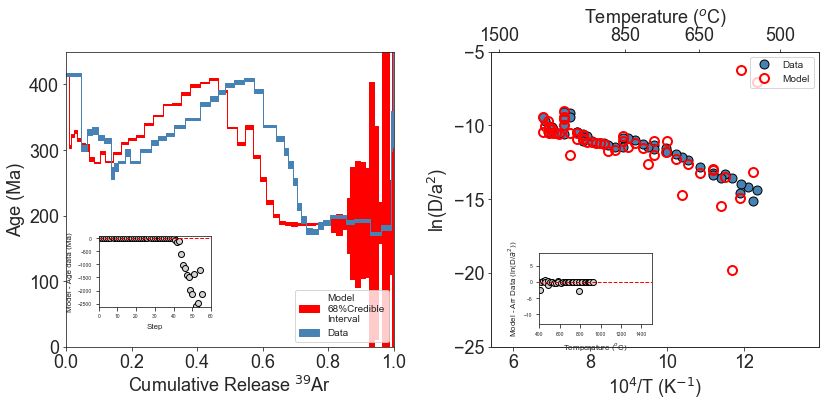

In [51]:
sns.set_style('ticks')

font= {"family": "Arial", 
      "weight": "normal",
      "size":18}

plt.rc("font", **font)


fig, ax = plt.subplots(1,2, figsize = (12, 6))

ax[0].fill_between(frel_model_plot, low2_plot, 
                 high2_plot, 
                 alpha = 1, 
                color = 'r', 
                label = 'Model\n68%Credible\nInterval', 
                  step = 'pre', 
                  interpolate = True,  
                  lw = 1)


ax[0].fill_between(ar39_plot, 
                age_plot + 2*age_plot_err, 
                age_plot - 2*age_plot_err, 
                color = 'steelblue', 
                step = 'pre', 
                label = 'Data')

ax[0].set_xlabel('Cumulative Release $^{39}$Ar')
ax[0].set_ylabel('Age (Ma)')




ax[1].plot(tplot[1:N], arr_data[1:N], 
          'o', markerfacecolor = 'steelblue', 
          markeredgecolor = 'k', 
          markersize = 9, label = 'Data')


ax[1].plot(tplot[-len(Z1):],Z1, 'or',
             markerfacecolor = 'None',
            alpha = 1, 
             markeredgecolor = 'r', markeredgewidth = 2, 
            markersize = 9, 
            label = 'Model')


#### Temp #####

ax2 = ax[1].twiny()

Tdc = np.array([500,  650, 850,  1500])
Tp = 10e3/(Tdc + 273.15)
labels = list(['500', '650', '850',   
              '1500'])
ax2.plot(tplot, arr_data, alpha = 0)
ax2.set_xlabel('Temperature ($^{o}$C)')
ax[1].set_xlim(Tp.min() - 0.2, Tp.max()+ 1)
ax2.set_xlim(Tp.min() -0.2, Tp.max()+ 1)

ax2.set_xlabel('Temperature ($^{o}$C)')
ax2.set_xticks(Tp)
ax2.set_xticklabels(labels)


ax3 =plt.axes([0.65,0.22,0.13,0.165])

ax3.plot(temp[0:N-1] - 273.15, Z1 - arr_data[0:N-1], 'ok', 
        markeredgecolor = 'k', 
        markerfacecolor = 'lightgrey')
qqq = Z1 - arr_data[0:N-1]
ax3.axhline(0, lw = 1, ls = '--', 
           color = 'r')
ax3.set_ylabel('Model - Arr Data (ln(D/$a^{2}$))', fontsize = 8)
ax3.set_xlabel('Temperature ($^{o}$C)', fontsize = 8)
ax3.set_ylim(qqq.min() - 1, qqq.max() + 1)
ax3.tick_params(labelsize = 5)
ax3.locator_params(axis='x', nbins=6)
ax3.set_xlim(400, 1500)

ax[1].set_xlabel('10$^{4}$/T (K$^{-1}$)')
ax[1].set_ylabel('ln(D/a$^{2}$)')
ax[1].locator_params(axis='y', nbins=6)
ax[1].locator_params(axis='x', nbins=6)


ax4 =plt.axes([0.14,0.26,0.13,0.165])

ax4.plot(np.linspace(1, N, N).astype(int), Z2 - data, 'ok', 
        markeredgecolor = 'k', 
        markerfacecolor = 'lightgrey')
qqq2 = Z2 - data
ax4.set_ylim(qqq2.min() - 50, qqq2.max() + 50)

ax4.axhline(0, lw = 1, ls = '--', 
           color = 'r')
ax4.set_ylabel('Model - Age data (Ma)', fontsize = 8)
ax4.set_xlabel('Step', fontsize = 8)
ax4.tick_params(labelsize = 5)
ax4.locator_params(axis='x', nbins=10)
ax4.set_xlim(0, N+5)
#ax[0].set_ylim(0, 300)
ax[0].set_xlim(0, 1)

ax[0].legend(loc = 4, fontsize = 10)
ax[1].legend(loc = 1, fontsize = 10)

plt.tight_layout()
ax[1].set_ylim(-25, -5)
ax[0].set_ylim(0, 450)


In [52]:
temp_plot = np.linspace(450, 1600, 20)
tplot_2 = 10000/temp_plot

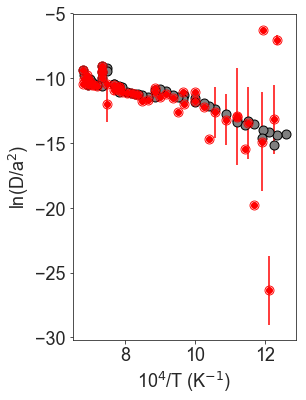

In [53]:
fig = plt.figure(figsize = (4,6))
low1, high1 = np.percentile(ppc['obs2'], [2.5, 97.5], axis = 0)
plt.plot(tplot, arr_data, 
          'o', markerfacecolor = 'grey', 
          markeredgecolor = 'k', 
          markersize = 9, label = 'Data')


plt.plot(tplot[-len(Z1):],Z1[-len(Z1):], 'or',
             markerfacecolor = 'None',
            alpha = 1, 
             markeredgecolor = 'r', markeredgewidth = 0.9, 
            markersize = 9, 
            label = 'Model')

plt.errorbar(tplot[-len(Z1):], Z1[-len(Z1):], 
           yerr = 2*(high1[-len(Z1):] - low1[-len(Z1):]),
           color = 'r', 
            fmt = 'o')

plt.xlabel('10$^{4}$/T (K$^{-1}$)')
plt.ylabel('ln(D/a$^{2}$)')
plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=6)


Text(0, 0.5, 'Cumulative density')

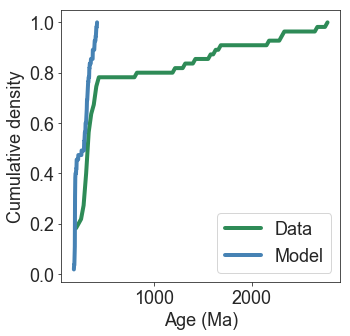

In [54]:
num_bins = 100 
counts, bin_edges = np.histogram(age, bins = num_bins, 
                                density = True)
cdf = np.cumsum(counts)

counts2, bin_edges2 = np.histogram(Z2, bins = num_bins, 
                                density = True)
cdf2 = np.cumsum(counts2)

fig = plt.figure(figsize = (5,5))
plt.plot(bin_edges[1:], cdf/cdf[-1], 
        label = 'Data', 
        lw = 4, 
        color = 'seagreen')
plt.plot(bin_edges2[1:], cdf2/cdf2[-1], 
        label = 'Model', 
        lw = 4,
        color = 'steelblue')

plt.legend()
plt.xlabel('Age (Ma)')
plt.ylabel('Cumulative density')

In [55]:
df_age = pd.DataFrame({"age_model": Z2, 
                      "age_model_low": low2,
                      "age_model_high": high2,
                      "frel_model": frel_model})

df_arr = pd.DataFrame({"arr_model":Z1,
                      "arr_model_low":low1,
                      "arr_model_high": high1})

df_age_comp = pd.DataFrame({"age1":trace['age_model'][:,0][-SAMPLES::10],
                           "age2":trace['age_model'][:,1][-SAMPLES::10],
                           "age3":trace['age_model'][:,2][-SAMPLES::10],
                            "age4":trace['age_model'][:,3][-SAMPLES::10],
                           "age5":trace['age_model'][:,4][-SAMPLES::10],
                           "age6":trace['age_model'][:,5][-SAMPLES::10],
                           "age7":trace['age_model'][:,6][-SAMPLES::10],
                           "age8":trace['age_model'][:,7][-SAMPLES::10],
                           "age9":trace['age_model'][:,8][-SAMPLES::10],
                           "age10":trace['age_model'][:,9][-SAMPLES::10],
                           "age11":trace['age_model'][:,10][-SAMPLES::10],
                           "age12":trace['age_model'][:,11][-SAMPLES::10],
                           "age13":trace['age_model'][:,12][-SAMPLES::10],
                           "age14":trace['age_model'][:,13][-SAMPLES::10]})

df_w_comp = pd.DataFrame({"w1":trace['K'][:,0][-SAMPLES::10],
                         "w2":trace['K'][:,1][-SAMPLES::10],
                         "w3":trace['K'][:,2][-SAMPLES::10],
                         "w4":trace['K'][:,3][-SAMPLES::10],
                         "w5":trace['K'][:,4][-SAMPLES::10],
                         "w6":trace['K'][:,5][-SAMPLES::10],
                         "w7":trace['K'][:,6][-SAMPLES::10],
                         "w8":trace['K'][:,7][-SAMPLES::10],
                         "w9":trace['K'][:,8][-SAMPLES::10],
                         "w10":trace['K'][:,9][-SAMPLES::10],
                         "w11":trace['K'][:,10][-SAMPLES::10],
                         "w12":trace['K'][:,11][-SAMPLES::10],
                         "w13":trace['K'][:,12][-SAMPLES::10],
                         "w14":trace['K'][:,13][-SAMPLES::10]})

In [56]:
df_age.to_csv("mc_fb1_age.csv")
df_arr.to_csv("mc_fb1_arr.csv")
df_age_comp.to_csv("mc_fb1_age_comp.csv")
df_w_comp.to_csv("mc_fb1_w_comp.csv")